# Genetic Algorithm for shortest path problem

In this code I will write an example of a genetic algorithm that tries to get from point (0,0) to (1000,0) in 10 steps.

* Each individual can go 100 unit at most on one direction at each step. So the shortest path is taking 100 units on the x axis on each 10 step without moving in y axis. However, this is very unlikely to achieve.
* At each generation, most successful 100 individual is selected for mating in the next generation.
* When creating a new generation, each indiviauls x and y move on each step is randomly passed to the new generation. However, there is a 10% mutation rate for any random number.
* Each individuals' success is calculated by its distance to the target (1000,0) point at the end of 10 steps. Additionally, it's moves on y axis are added to this distance. So a successful individual should go far on the x axis, without moving much on the y axis.

### Importing required libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Creating the 1st generation

* The 1st generation is created entirely randomly.
* For the first generation, there is a step size limit. No individual can move more than 100 on x and y axes combined. So an individual can take a step like (50,50), (100,0), (-50,-50) and so on.

In [17]:
step_no = np.arange(1,11) # how many steps do you want each character to take
figure_no = np.arange(1,10001) # how many characters do you want
step_size = 100 # size of each step

figures_raw_data = []

for f in figure_no:
    figure = f
    step = 0
    x_move = 0
    y_move = 0
    x_position = 0
    y_position = 0
    y_total_move = 0
    figures_raw_data.append([figure,step,x_move,y_move,x_position,y_position])
    
    for s in step_no:
        figure = f
        step = s
        x_move = np.random.randint(0-step_size,1+step_size) # for step_size=10 it brings a integer between -100 and 100
        step_remaining = step_size - abs(x_move)
        y_move = np.random.randint(0-step_remaining, 1+step_remaining)
        x_position = x_position + x_move
        y_position = y_position + y_move
        y_total_move = y_total_move + abs(y_move)
        figures_raw_data.append([figure,step,x_move,y_move,x_position,y_position,y_total_move])

df = pd.DataFrame(figures_raw_data, columns=['figure','step','x_move','y_move','x_position','y_position','y_total_move'])

# choosing the top 100 figure
df_success = df[df['step']==10]
df_success['distance'] = np.sqrt((1000-df['x_position'])**2 + (0-df['y_position'])**2) + df['y_total_move']
df_success['rank'] = df_success['distance'].rank(method='first')
df_success['label'] = np.where(df_success['rank']<=100, 'successful', 'not successful')

# printing the results
print('Average distance of all population: '+str(df_success['distance'].mean()))
print('Average distance of successful population: '+str(df_success[df_success['label']=='successful']['distance'].mean()))
print('Average distance of top 10 population: '+str(df_success[df_success['rank']<=10]['distance'].mean()))


# merging tables
df = pd.merge(df, df_success[['figure','rank','label','distance']], how='inner', on='figure')

# copying df to keep all generations
df_generations = df.copy()
df_generations['generation'] = 1

Average distance of all population: 1256.7763833694667
Average distance of successful population: 720.4236541569661
Average distance of top 10 population: 584.0672193693787


Movement of first individual
> This individual went from (0,0) to (249,64) making it the 1460th successful individual. Since it was not in top 100, it was eliminated.

In [18]:
df.head(11)

,figure,step,x_move,y_move,x_position,y_position,y_total_move,rank,label,distance
0,1,0,0,0,0,0,NaN,1460.0,not successful,1045.722097
1,1,1,-5,-27,-5,-27,27.0,1460.0,not successful,1045.722097
2,1,2,88,1,83,-26,28.0,1460.0,not successful,1045.722097
3,1,3,54,38,137,12,66.0,1460.0,not successful,1045.722097
4,1,4,7,90,144,102,156.0,1460.0,not successful,1045.722097
5,1,5,62,20,206,122,176.0,1460.0,not successful,1045.722097
6,1,6,78,12,284,134,188.0,1460.0,not successful,1045.722097
7,1,7,79,-1,363,133,189.0,1460.0,not successful,1045.722097
8,1,8,-11,-64,352,69,253.0,1460.0,not successful,1045.722097
9,1,9,-71,17,281,86,270.0,1460.0,not successful,1045.722097


Creating the visualization

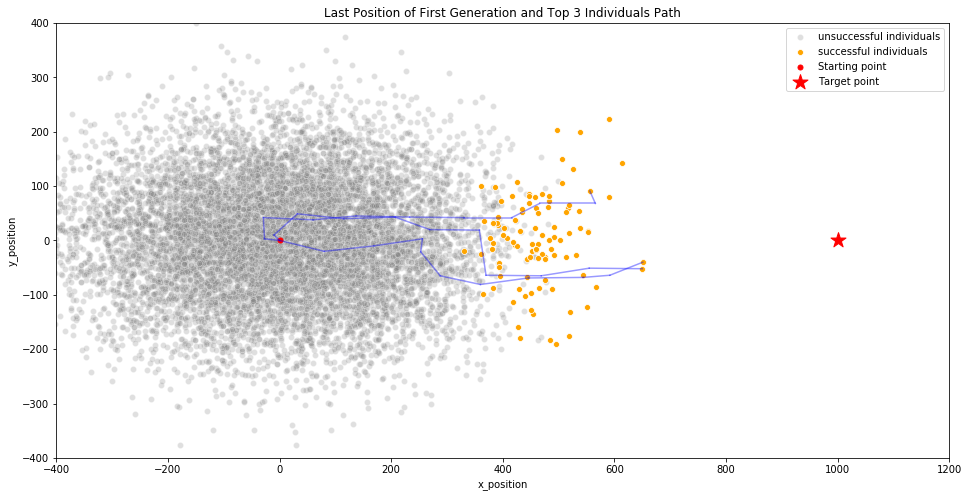

In [19]:
step = np.arange(0,11)
figure = np.arange(1,4)

fig = plt.figure(figsize=(16,8));
# unsuccessful individuals
sns.scatterplot(data=df[(df['step']==10) & (df['label']=='not successful')], 
                x='x_position', y='y_position', color='grey', alpha=0.25, label='unsuccessful individuals');

# successful individuals
sns.scatterplot(data=df[(df['step']==10) & (df['label']=='successful')], 
                x='x_position', y='y_position', color='orange', label='successful individuals');

# plotting top 3 individiual's path
for f in figure:
    for i in step:
        sns.lineplot(data=df[(df['rank']==f) & ((df['step']==i) | (df['step']==(i+1)))], 
                     x='x_position', y='y_position', color='blue', alpha=0.4);
        
    
plt.xlim(-400,1200);
plt.ylim(-400,400);
plt.scatter(0, 0, c='red', marker='.', s=100, label='Starting point');
plt.scatter(1000, 0, c='red', marker='*', s=250, label='Target point');
plt.title('Last Position of First Generation and Top 3 Individuals Path')
plt.legend();

### Creating the 2nd generation

* 2nd generation is created by mating the top 100 individuals of 1st generation.

In [20]:
# selecting top 100
df_successful_ones = df[df['label']=='successful']
df_successful_ones['figure'] = df_successful_ones['rank'].astype(int)
df_successful_ones.drop(['rank', 'label'], axis=1, inplace=True)
df_successful_ones.sort_values(by=['figure', 'step'], inplace=True)
df_successful_ones = df_successful_ones[df_successful_ones['step']!=0]

male = np.arange(1,101)
female = np.arange(1,101)
step_no = np.arange(1,11)
step_size = 100 # size of each step

figures_raw_data = []
i = 1

for m in male:
    
    for f in female:
        data = df_successful_ones[(df_successful_ones['figure']==m) | (df_successful_ones['figure']==f)]
        x_position = 0
        y_position = 0
        y_total_move = 0
        figures_raw_data.append([i,0,0,0,0,0,0])
        
        for s in step_no:
            x_move_m = np.int(data[(data['figure']==m) & (data['step']==s)]['x_move'])
            x_move_f = np.int(data[(data['figure']==f) & (data['step']==s)]['x_move'])
            x_move = np.random.choice([x_move_m,x_move_f,np.random.randint(0-step_size,1+step_size)], p=(0.45,0.45,0.1))
            
            y_move_m = np.int(data[(data['figure']==m) & (data['step']==s)]['y_move'])
            y_move_f = np.int(data[(data['figure']==f) & (data['step']==s)]['y_move'])
            y_move = np.random.choice([y_move_m,y_move_f,np.random.randint(0-step_size,1+step_size)], p=(0.45,0.45,0.1))
            
            x_position = x_position + x_move
            y_position = y_position + y_move
            y_total_move = y_total_move + abs(y_move)
            
            figures_raw_data.append([i,s,x_move,y_move,x_position,y_position,y_total_move])
            print('male: ' + str(m) + '- female: ' + str(f) + '       ', end='\r')
        
        i = i+1
            
# converting to dataframe            
df = pd.DataFrame(figures_raw_data, columns=['figure','step','x_move','y_move','x_position','y_position','y_total_move'])

#sorting the dataframe
df.sort_values(by=['figure', 'step'], inplace=True)

# choosing the top 100 figure
df_success = df[df['step']==10]
df_success['distance'] = np.sqrt((1000-df['x_position'])**2 + (0-df['y_position'])**2) + df['y_total_move']
df_success['rank'] = df_success['distance'].rank(method='first')
df_success['label'] = np.where(df_success['rank']<=100, 'successful', 'not successful')

# printing the results
print('Average distance of all population: '+str(df_success['distance'].mean()))
print('Average distance of successful population: '+str(df_success[df_success['label']=='successful']['distance'].mean()))
print('Average distance of top 10 population: '+str(df_success[df_success['rank']<=10]['distance'].mean()))


# merging tables
df = pd.merge(df, df_success[['figure','rank','label','distance']], how='inner', on='figure')

Average distance of all population: 800.2075695509312
Average distance of successful population: 444.7776169008215
Average distance of top 10 population: 369.4489078256672


Creating the visualization for 2nd generation

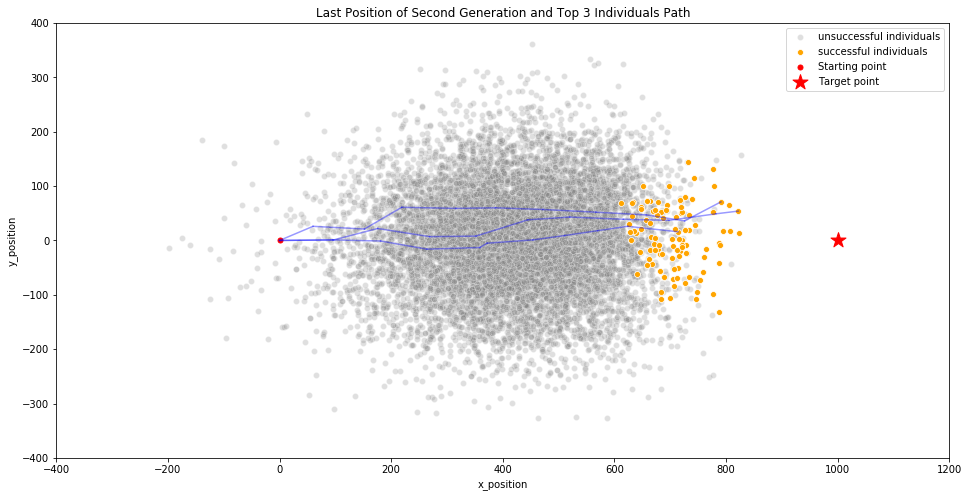

In [21]:
step = np.arange(0,11)
figure = np.arange(1,4)

fig = plt.figure(figsize=(16,8));
# unsuccessful individuals
sns.scatterplot(data=df[(df['step']==10) & (df['label']=='not successful')], 
                x='x_position', y='y_position', color='grey', alpha=0.25, label='unsuccessful individuals');

# successful individuals
sns.scatterplot(data=df[(df['step']==10) & (df['label']=='successful')], 
                x='x_position', y='y_position', color='orange', label='successful individuals');

# plotting top 3 individiual's path
for f in figure:
    for i in step:
        sns.lineplot(data=df[(df['rank']==f) & ((df['step']==i) | (df['step']==(i+1)))], 
                     x='x_position', y='y_position', color='blue', alpha=0.4);
        
    
plt.xlim(-400,1200);
plt.ylim(-400,400);
plt.scatter(0, 0, c='red', marker='.', s=100, label='Starting point');
plt.scatter(1000, 0, c='red', marker='*', s=250, label='Target point');
plt.title('Last Position of Second Generation and Top 3 Individuals Path')
plt.legend();

Keeping all the generations

In [22]:
df_generations_append = df.copy()
df_generations_append['generation'] = 2
df_generations = df_generations.append(df_generations_append)
df_generations.groupby('generation').count()

,figure,step,x_move,y_move,x_position,y_position,y_total_move,rank,label,distance
generation,,,,,,,,,,
1,110000,110000,110000,110000,110000,110000,100000,110000,110000,110000
2,110000,110000,110000,110000,110000,110000,110000,110000,110000,110000


### Creating further generations

In [23]:
generation = np.arange(3,21)

for g in generation:
    
    print('Generation ' + str(g) + ' started')
    
    # selecting top 100
    df_successful_ones = df[df['label']=='successful']
    df_successful_ones['figure'] = df_successful_ones['rank'].astype(int)
    df_successful_ones.drop(['rank', 'label'], axis=1, inplace=True)
    df_successful_ones.sort_values(by=['figure', 'step'], inplace=True)
    df_successful_ones = df_successful_ones[df_successful_ones['step']!=0]

    male = np.arange(1,101)
    female = np.arange(1,101)
    step_no = np.arange(1,11)
    step_size = 100 # size of each step

    figures_raw_data = []
    i = 1

    for m in male:

        for f in female:
            data = df_successful_ones[(df_successful_ones['figure']==m) | (df_successful_ones['figure']==f)]
            x_position = 0
            y_position = 0
            y_total_move = 0
            figures_raw_data.append([i,0,0,0,0,0,0])

            for s in step_no:
                x_move_m = np.int(data[(data['figure']==m) & (data['step']==s)]['x_move'])
                x_move_f = np.int(data[(data['figure']==f) & (data['step']==s)]['x_move'])
                x_move = np.random.choice([x_move_m,x_move_f,np.random.randint(0-step_size,1+step_size)], p=(0.45,0.45,0.1))

                y_move_m = np.int(data[(data['figure']==m) & (data['step']==s)]['y_move'])
                y_move_f = np.int(data[(data['figure']==f) & (data['step']==s)]['y_move'])
                y_move = np.random.choice([y_move_m,y_move_f,np.random.randint(0-step_size,1+step_size)], p=(0.45,0.45,0.1))

                x_position = x_position + x_move
                y_position = y_position + y_move
                y_total_move = y_total_move + abs(y_move)

                figures_raw_data.append([i,s,x_move,y_move,x_position,y_position,y_total_move])
                print('male: ' + str(m) + '- female: ' + str(f) + '       ', end='\r')

            i = i+1

    # converting to dataframe            
    df = pd.DataFrame(figures_raw_data, columns=['figure','step','x_move','y_move','x_position','y_position','y_total_move'])

    #sorting the dataframe
    df.sort_values(by=['figure', 'step'], inplace=True)

    # choosing the top 100 figure
    df_success = df[df['step']==10]
    df_success['distance'] = np.sqrt((1000-df['x_position'])**2 + (0-df['y_position'])**2) + df['y_total_move']
    df_success['rank'] = df_success['distance'].rank(method='first')
    df_success['label'] = np.where(df_success['rank']<=100, 'successful', 'not successful')

    # printing the results
    print('Generation ' + str(g) + ' results:       ')
    print('Average distance of all population: '+str(df_success['distance'].mean()))
    print('Average distance of successful population: '+str(df_success[df_success['label']=='successful']['distance'].mean()))
    print('Average distance of top 10 population: '+str(df_success[df_success['rank']<=10]['distance'].mean()))
    print('Distance of the best individual: '+str(df_success[df_success['rank']==1]['distance'].mean()))

    # merging tables
    df = pd.merge(df, df_success[['figure','rank','label','distance']], how='inner', on='figure')
    
    # copying all generations to df_generations
    df_generations_append = df.copy()
    df_generations_append['generation'] = g
    df_generations = df_generations.append(df_generations_append)
    print('Generation ' + str(g) + ' data stored')
    print('----------------------------------')
    print('\n')

Generation 3 started
Generation 3 results:        
Average distance of all population: 553.9140060320456
Average distance of successful population: 280.27068385084164
Average distance of top 10 population: 231.80846961671097
Distance of the best individual: 198.6291201783626
Generation 3 data stored
----------------------------------


Generation 4 started
Generation 4 results:        
Average distance of all population: 409.51942061593735
Average distance of successful population: 186.10040254363676
Average distance of top 10 population: 154.43902846762813
Distance of the best individual: 131.2165848854662
Generation 4 data stored
----------------------------------


Generation 5 started
Generation 5 results:        
Average distance of all population: 326.01113409531604
Average distance of successful population: 125.31202360562091
Average distance of top 10 population: 100.12013034729026
Distance of the best individual: 90.17583859709698
Generation 5 data stored
---------------------

Exporting the data

In [30]:
df_generations[(df_generations['generation']>=1) & (df_generations['generation']<=5)].to_excel('generations_1_5.xlsx',sheet_name='Sheet1')
df_generations[(df_generations['generation']>=6) & (df_generations['generation']<=10)].to_excel('generations_6_10.xlsx',sheet_name='Sheet1')
df_generations[(df_generations['generation']>=11) & (df_generations['generation']<=15)].to_excel('generations_11_15.xlsx',sheet_name='Sheet1')
df_generations[(df_generations['generation']>=16) & (df_generations['generation']<=20)].to_excel('generations_16_20.xlsx',sheet_name='Sheet1')
print('All generation data is exported as xlsx file.')

All generation data is exported as xlsx file.


### Visualizing the 20th generation

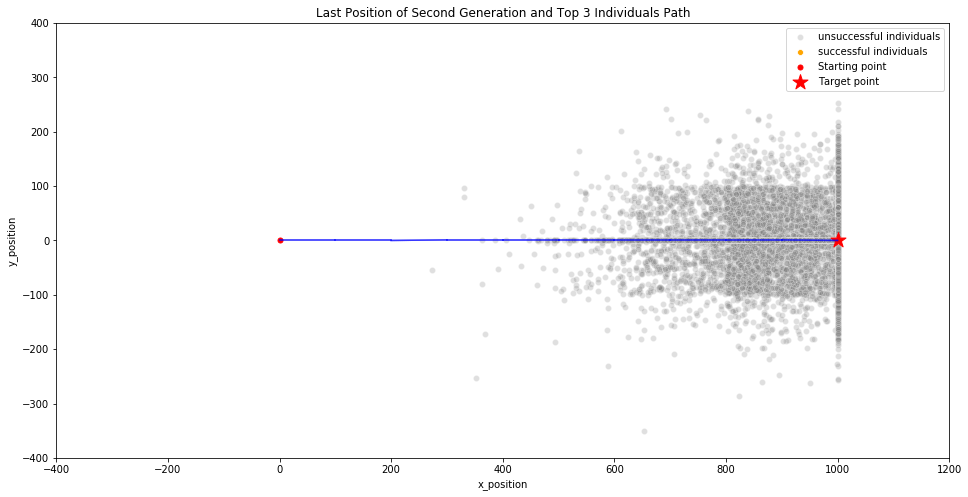

In [31]:
step = np.arange(0,11)
figure = np.arange(1,4)

fig = plt.figure(figsize=(16,8));
# unsuccessful individuals
sns.scatterplot(data=df[(df['step']==10) & (df['label']=='not successful')], 
                x='x_position', y='y_position', color='grey', alpha=0.25, label='unsuccessful individuals');

# successful individuals
sns.scatterplot(data=df[(df['step']==10) & (df['label']=='successful')], 
                x='x_position', y='y_position', color='orange', label='successful individuals');

# plotting top 3 individiual's path
for f in figure:
    for i in step:
        sns.lineplot(data=df[(df['rank']==f) & ((df['step']==i) | (df['step']==(i+1)))], 
                     x='x_position', y='y_position', color='blue', alpha=0.4);
        
    
plt.xlim(-400,1200);
plt.ylim(-400,400);
plt.scatter(0, 0, c='red', marker='.', s=100, label='Starting point');
plt.scatter(1000, 0, c='red', marker='*', s=250, label='Target point');
plt.title('Last Position of Second Generation and Top 3 Individuals Path')
plt.legend();

#### Score of the best individual in 20th generation
> Check that it directly lands on (1000,0) point at the end with very minor move in y-axis. 

In [32]:
df[df['rank']==1]

,figure,step,x_move,y_move,x_position,y_position,y_total_move,rank,label,distance
0,1,0,0,0,0,0,0,1.0,successful,2.0
1,1,1,100,0,100,0,0,1.0,successful,2.0
2,1,2,100,0,200,0,0,1.0,successful,2.0
3,1,3,100,1,300,1,1,1.0,successful,2.0
4,1,4,100,0,400,1,1,1.0,successful,2.0
5,1,5,100,0,500,1,1,1.0,successful,2.0
6,1,6,100,0,600,1,1,1.0,successful,2.0
7,1,7,100,0,700,1,1,1.0,successful,2.0
8,1,8,100,0,800,1,1,1.0,successful,2.0
9,1,9,100,0,900,1,1,1.0,successful,2.0


#### Top performing individuals' last position of each generation

In [26]:
df_generations[(df_generations['rank']==1) & (df_generations['step']==10)]

,figure,step,x_move,y_move,x_position,y_position,y_total_move,rank,label,distance,generation
95116,8647,10,59,24,651,-40,168.0,1.0,successful,519.284785,1
46364,4215,10,40,5,822,54,96.0,1.0,successful,282.010752,2
30810,2801,10,95,5,875,50,64.0,1.0,successful,198.629120,3
22967,2088,10,91,-2,917,-6,48.0,1.0,successful,131.216585,4
77065,7006,10,95,1,929,5,19.0,1.0,successful,90.175839,5
4498,409,10,95,5,963,4,28.0,1.0,successful,65.215588,6
105665,9606,10,98,2,987,-9,21.0,1.0,successful,36.811388,7
4520,411,10,99,-2,987,2,16.0,1.0,successful,29.152946,8
36387,3308,10,98,2,987,3,7.0,1.0,successful,20.341664,9
1231,112,10,99,1,992,0,8.0,1.0,successful,16.000000,10


### Visualizations

Top performer's distance in each generation

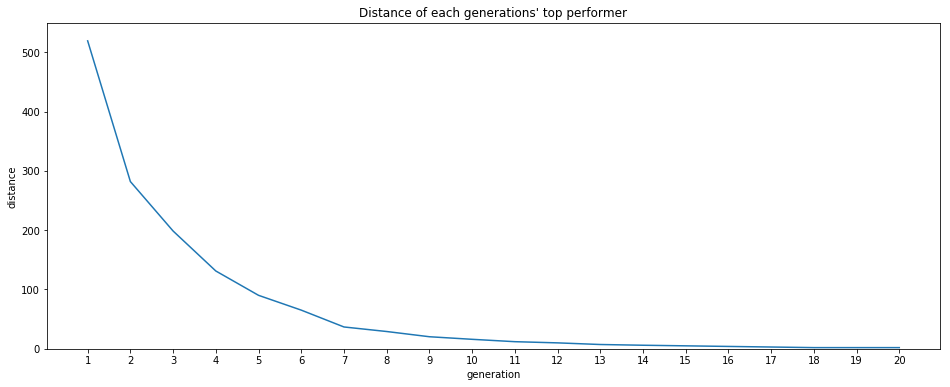

In [63]:
# getting top performer on each generation
df_graph = df_generations[(df_generations['rank']==1) & (df_generations['step']==10)]


fig = plt.figure(figsize=(16,6));
plt.xticks(np.arange(21));
sns.lineplot(x='generation', y='distance', data=df_graph);
plt.title("Distance of each generations' top performer");
plt.ylim(0,550);

Plotting the generations
> You can see the results of different generations on the folder.

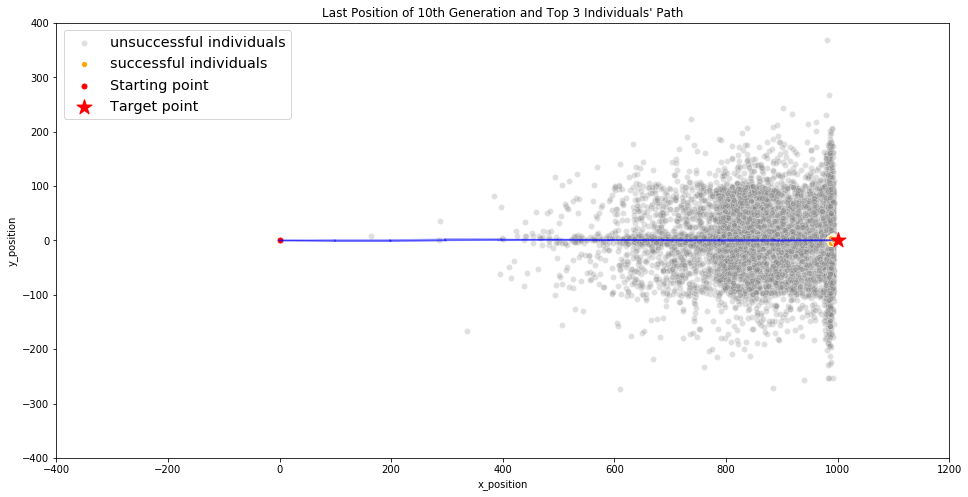

In [66]:
df_graph = df_generations[df_generations['generation']==10]

step = np.arange(0,11)
figure = np.arange(1,4)

fig = plt.figure(figsize=(16,8));
# unsuccessful individuals
sns.scatterplot(data=df_graph[(df_graph['step']==10) & (df_graph['label']=='not successful')], 
                x='x_position', y='y_position', color='grey', alpha=0.25, label='unsuccessful individuals');

# successful individuals
sns.scatterplot(data=df_graph[(df_graph['step']==10) & (df_graph['label']=='successful')], 
                x='x_position', y='y_position', color='orange', label='successful individuals');

# plotting top 3 individiual's path
for f in figure:
    for i in step:
        sns.lineplot(data=df_graph[(df_graph['rank']==f) & ((df_graph['step']==i) | (df_graph['step']==(i+1)))], 
                     x='x_position', y='y_position', color='blue', alpha=0.4);
        
    
plt.xlim(-400,1200);
plt.ylim(-400,400);
plt.scatter(0, 0, c='red', marker='.', s=100, label='Starting point');
plt.scatter(1000, 0, c='red', marker='*', s=250, label='Target point');
plt.title("Last Position of 10th Generation and Top 3 Individuals' Path")
plt.legend(fontsize='x-large');

fig.savefig("gen10.png", dpi=1000)

Paths of each generations' top performer

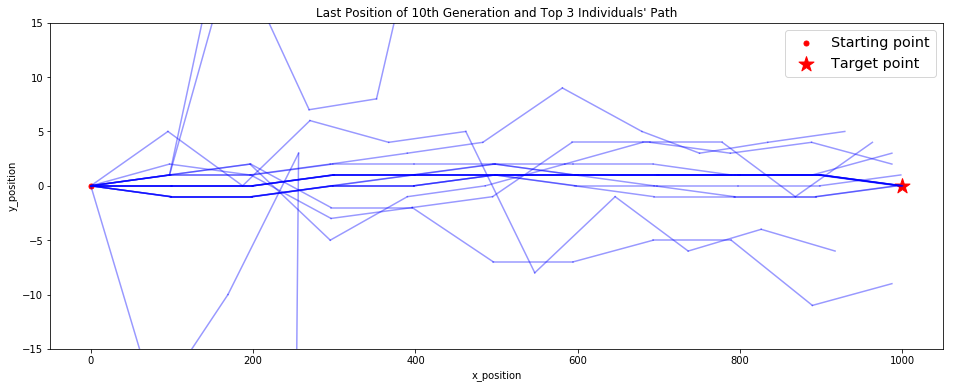

In [76]:
# getting top performer on each generation
df_graph = df_generations[df_generations['rank']==1]

step = np.arange(0,11)
gen = np.arange(1,21)

fig = plt.figure(figsize=(16,6));

# plotting top 3 individiual's path
for f in gen:
    for i in step:
        sns.lineplot(data=df_graph[(df_graph['generation']==f) & ((df_graph['step']==i) | (df_graph['step']==(i+1)))], 
                     x='x_position', y='y_position', color='blue', alpha=0.4);
        
plt.xlim(-50,1050);
plt.ylim(-15,15);
plt.scatter(0, 0, c='red', marker='.', s=100, label='Starting point');
plt.scatter(1000, 0, c='red', marker='*', s=250, label='Target point');
plt.title("Last Position of 10th Generation and Top 3 Individuals' Path")
plt.legend(fontsize='x-large');